# Downstram Analysis of the results of the Deconvolution: Using All the samples

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd
import seaborn as sns

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
results_folder = 'Cell2Location/results/'
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_14experiments_36clusters_20654locations_4188genes'}

# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [3]:
sp_data_file = results_folder +r['run_name']+'/sp.h5ad'

adata_vis = anndata.read(sp_data_file)

We have to remove our low quality sample. 

In [4]:
adata_vis.obs

in_tissue  array_row  array_col  \
spot_id                                                                        
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1          1         50        102   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1          1         59         19   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1          1         61         97   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1          1         45        115   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1          1         42         28   
...                                                ...        ...        ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1                1         22         42   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1                1         24         64   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1                1         31         77   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1                1         58         42   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1                1         45         27   

                                                               sample  \
spot_id                                                                 
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1  Count_SN048_A121573_Rep1   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1  Count_SN048_A121573_Rep1   
...                                                               ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1              SN123_A938797_Rep1   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1              SN123_A938797_Rep1   

                                             n_genes_by_counts  \
spot_id                                                          
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1               5341   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1               5674   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1               3170   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1               6756   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1               4295   
...                                                        ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1                     2339   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1                     3280   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1                     4068   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1                     3365   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1                     2805   

                                             log1p_n_genes_by_counts  \
spot_id                                                                
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1                 8.583355   
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1                 8.643826   
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1                 8.061802   
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1                 8.818334   
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1                 8.365440   
...                                                              ...   
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1                       7.757906   
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1                       8.095904   
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1                       8.311153   
SN123_A938797_Rep1_TTGTTTCACATCCAGG-1                       8.121480   
SN123_A938797_Rep1_TTGTTTCCATACAACT-1                       7.939515   

                                             total_counts  log1p_total_counts  \
spot_id                                                                         
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1       17364.0            9.762212   
Count_SN048_A12

# 1.- Clustering based on cell abundances

### Low Resolution = 0.25 (Few clusters)

In [5]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 30)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.25)

# add region as categorical variable
adata_vis.obs["region_cluster_025"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster_025"] =  adata_vis.obs["region_cluster_025"].astype("category")

In [6]:
sc.tl.umap(adata_vis, min_dist = 0.75, spread = 1)

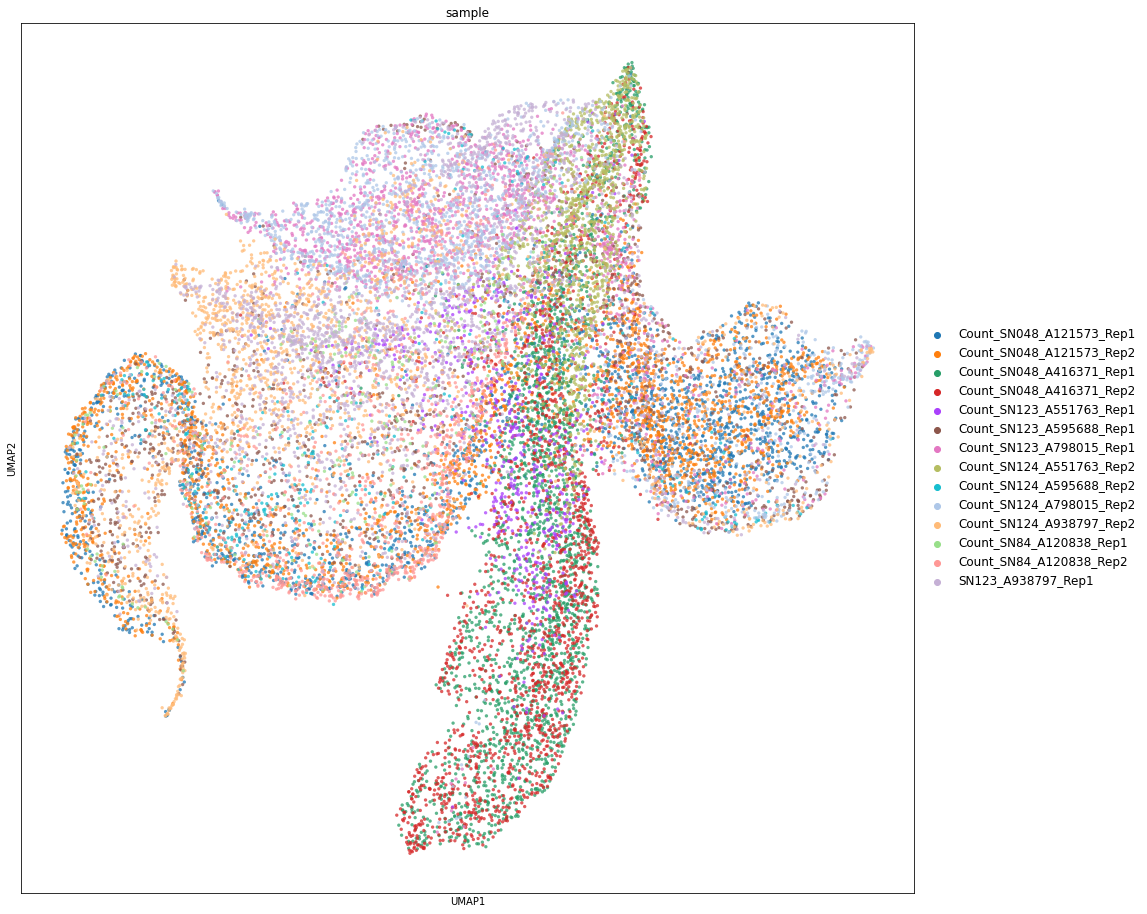

In [7]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['sample'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

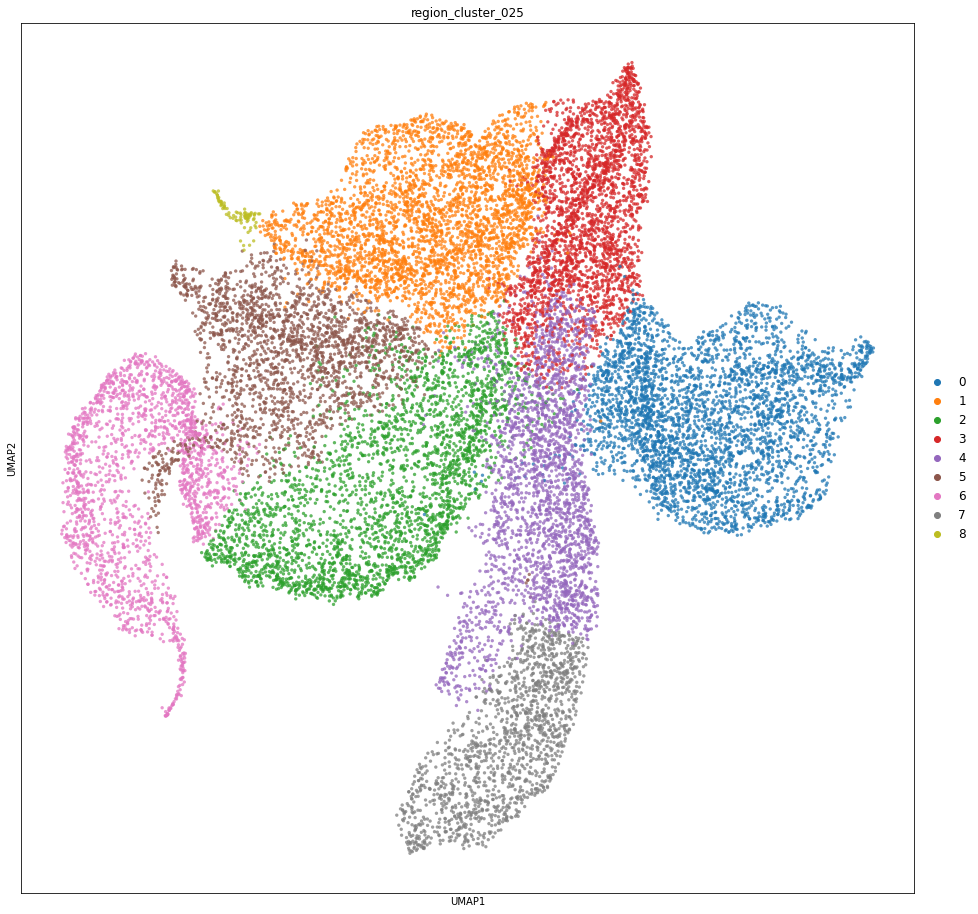

In [8]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['region_cluster_025'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

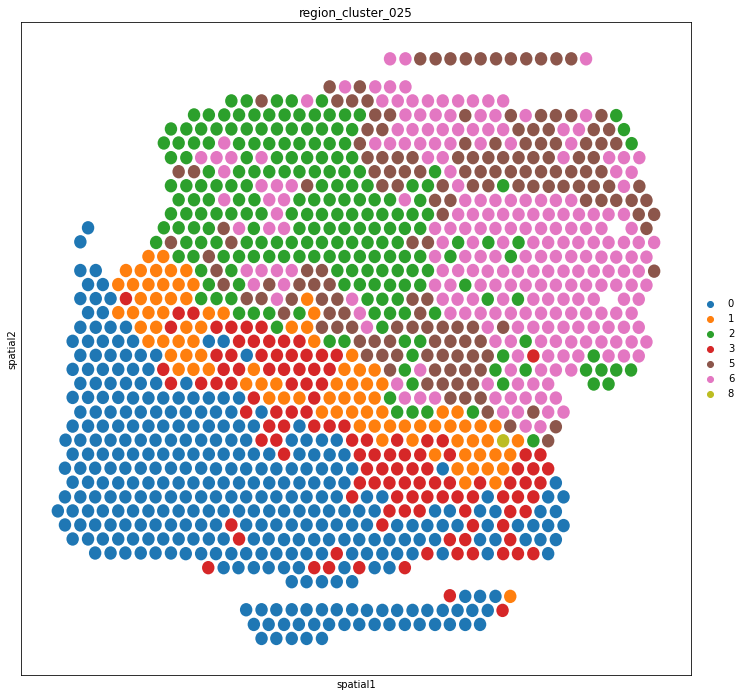

In [9]:
with mpl.rc_context({'figure.figsize': (12, 12)}):
  sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="Count_SN123_A595688_Rep1"],
                  color=["region_cluster_025"], size= 0.15, img_key=None
                )

### Higher Resolution = 0.75 (More clusters)


In [10]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 30)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.75)

# add region as categorical variable
adata_vis.obs["region_cluster_075"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster_075"] =  adata_vis.obs["region_cluster_075"].astype("category")

In [11]:
sc.tl.umap(adata_vis, min_dist = 0.75, spread = 1)

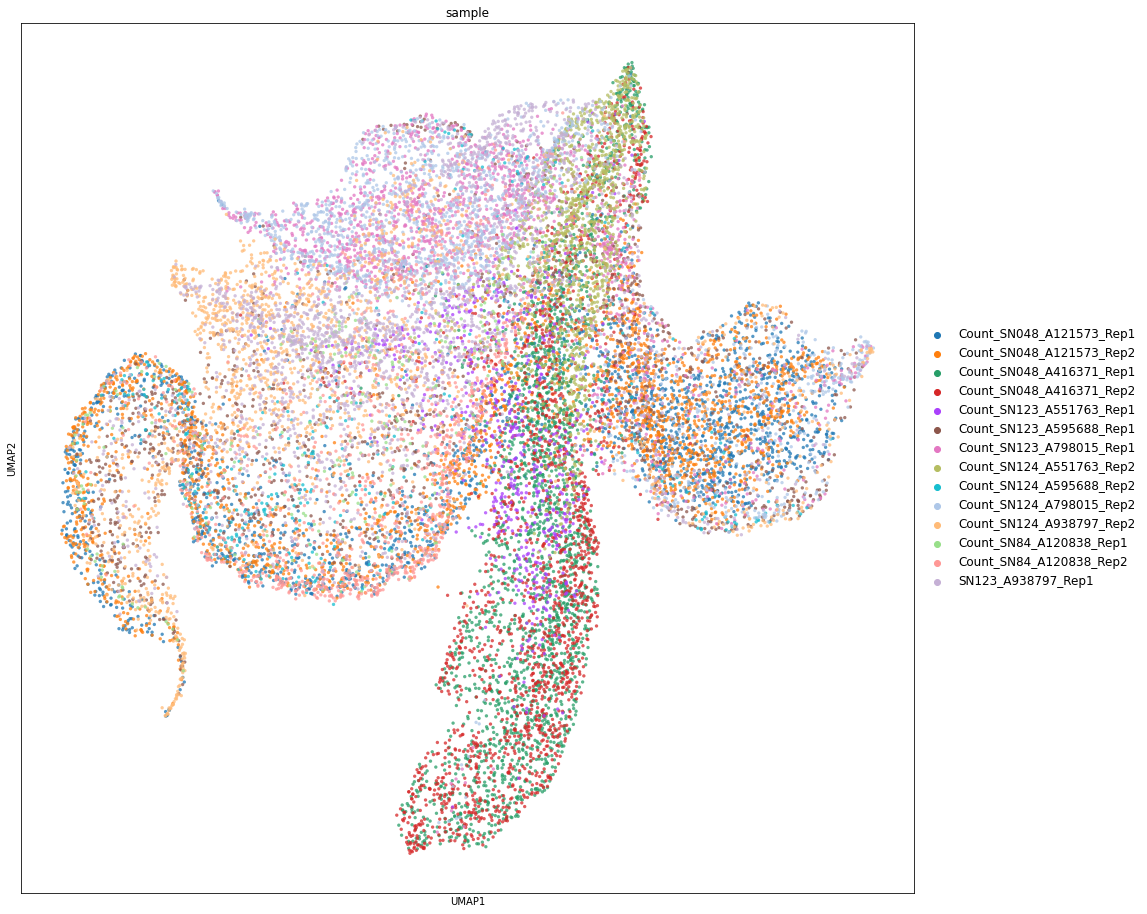

In [12]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['sample'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

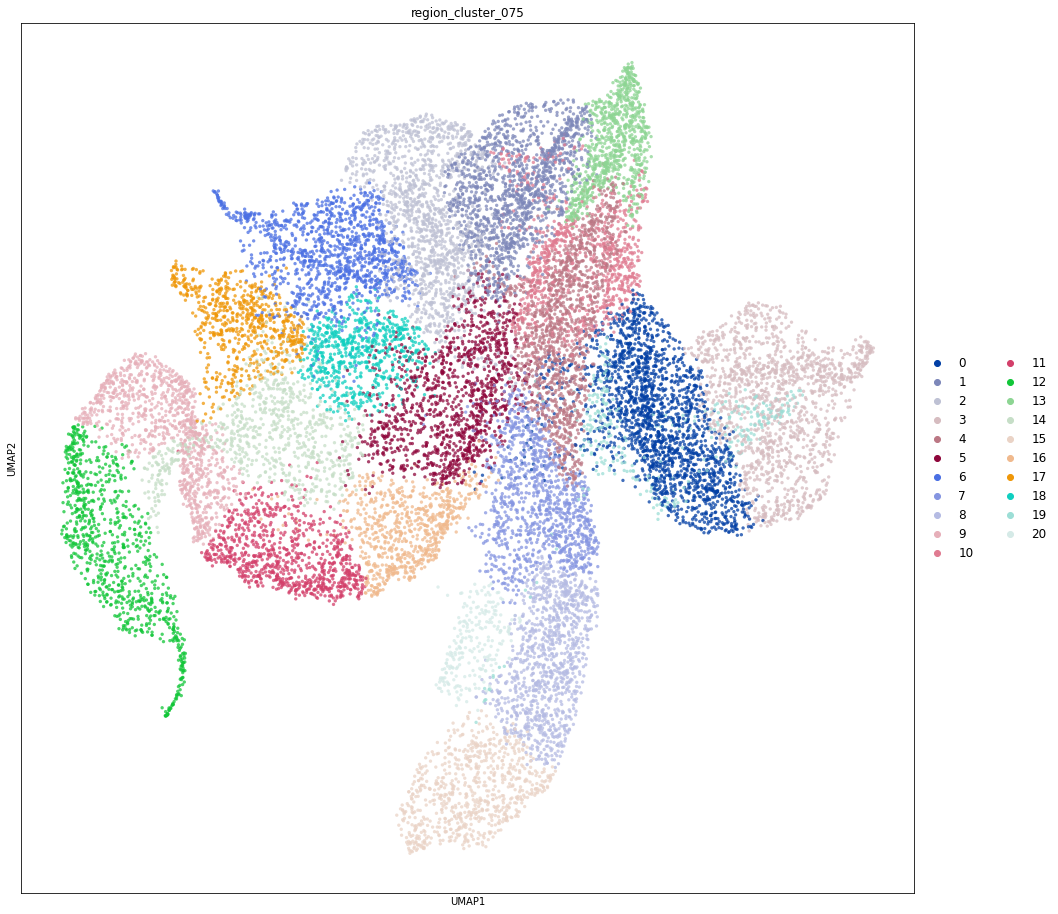

In [13]:
with mpl.rc_context({'figure.figsize': (16, 16)}):
    sc.pl.umap(adata_vis, color=['region_cluster_075'], size=45,
               color_map = 'RdPu',
               legend_fontsize=12, alpha=0.75)

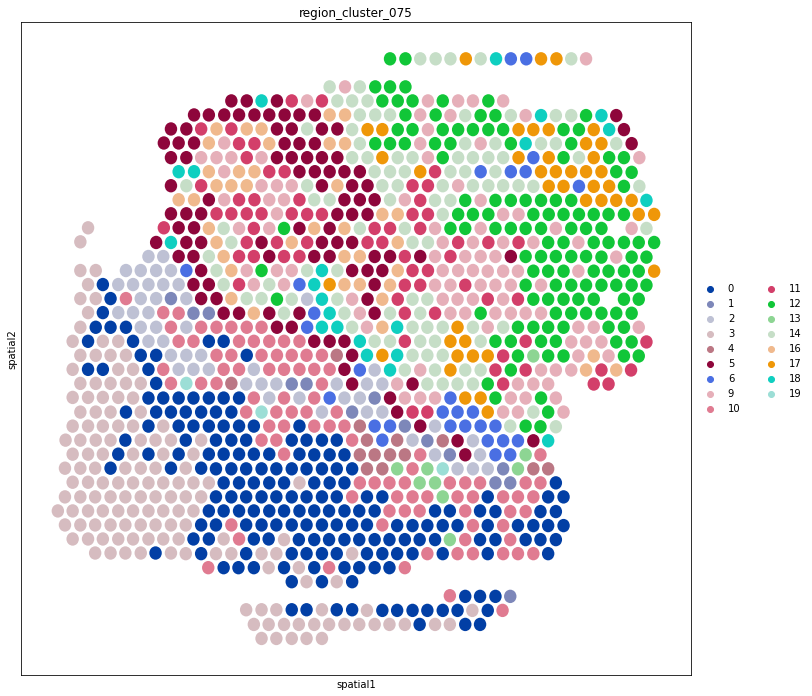

In [14]:
with mpl.rc_context({'figure.figsize': (12, 12)}):
  sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="Count_SN123_A595688_Rep1"],
                  color=["region_cluster_075"], size= 0.15, img_key=None
                )

We save the results to compute the Neigborhod enrichment analysis in the following script.

In [15]:
sp_data_New_file = results_folder +r['run_name']+'/sp_clusters_proportions.h5ad'
adata_vis.write(filename=sp_data_New_file)

## 2.- Cell types abundances per sample

In [16]:
samples = {'sample_name': ['Count_SN048_A121573_Rep1', 'Count_SN048_A121573_Rep2', 'Count_SN048_A416371_Rep1', 
    'Count_SN048_A416371_Rep2','Count_SN123_A551763_Rep1', 'Count_SN123_A595688_Rep1', 'Count_SN123_A798015_Rep1', 
    'Count_SN124_A551763_Rep2','Count_SN124_A595688_Rep2','Count_SN124_A798015_Rep2',
    'Count_SN124_A938797_Rep2','Count_SN84_A120838_Rep1','Count_SN84_A120838_Rep2', 'SN123_A938797_Rep1']}
sample_data = pd.DataFrame(data=samples)
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
df=pd.DataFrame()

In [17]:
for i in sample_data['sample_name']:
    adata_sample = adata_vis.obs.query('sample == @i')
    adata_sample_celltypes = adata_sample.loc[:,col_ind]
    per_sample_percelltype_counts = adata_sample_celltypes.sum()
    df[i] = per_sample_percelltype_counts

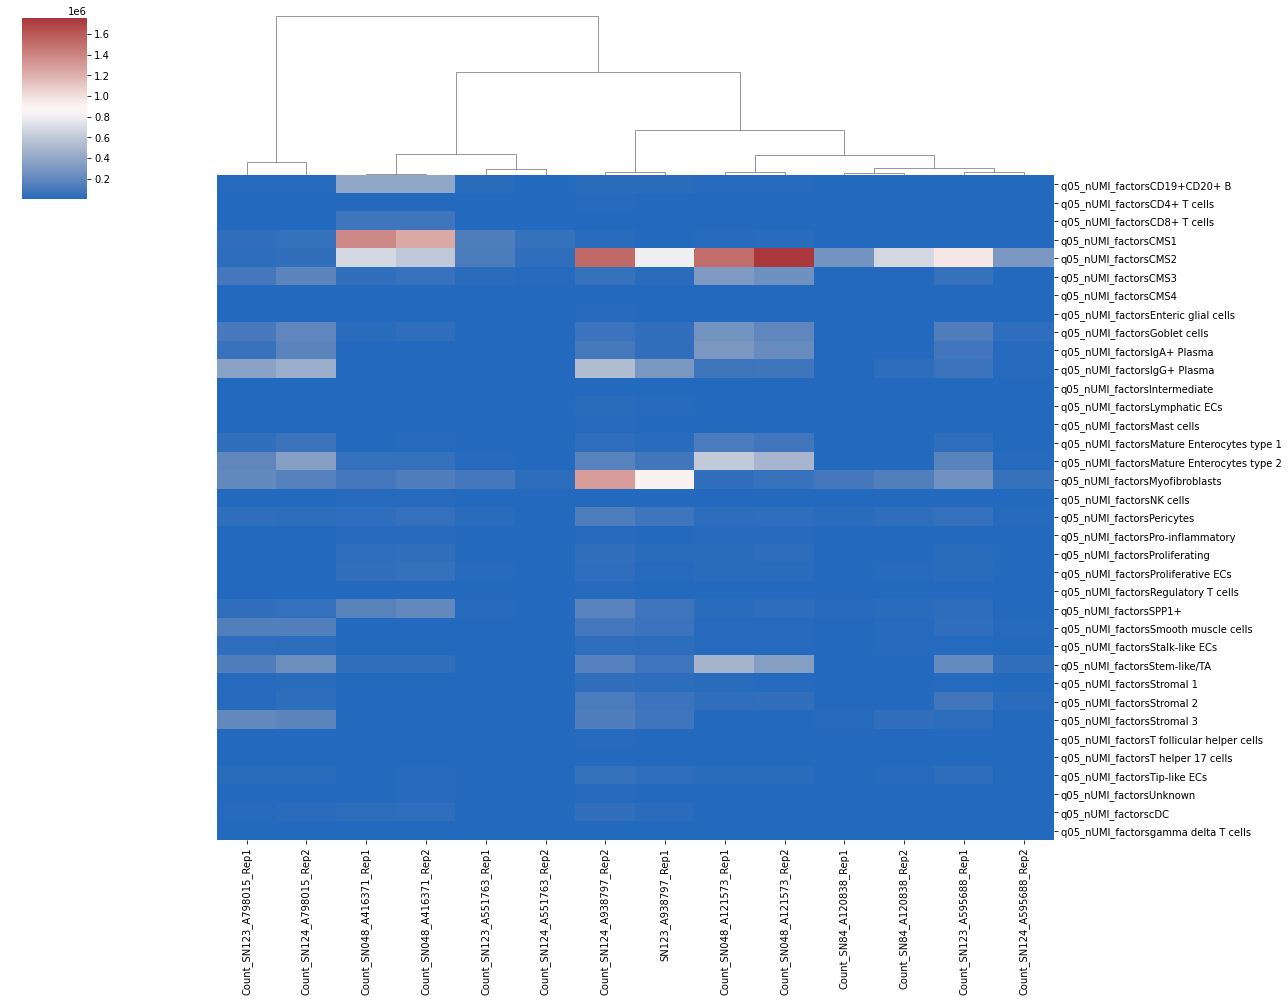

In [18]:
g = sns.clustermap(df,figsize=(18, 14),row_cluster=False,cmap="vlag", metric='correlation')

### 3-. Identify groups of co-located cell types using matrix factorisation

From Cell2Location tutorial: Tip If you want to find a few most disctinct cellular compartments, use a small number of factors. If you want to find very strong co-location signal and assume that most cell types don’t co-locate, use a lot of factors (> 30 - used here). In practice, it is better to train NMF for a range of factors R=5,..,30 and select R as a balance between capturing fine tissue zones and splitting known compartments

In [19]:
samples_to_consider = ['Count_SN048_A121573_Rep1', 'Count_SN048_A121573_Rep2', 'Count_SN048_A416371_Rep1', 
    'Count_SN048_A416371_Rep2','Count_SN123_A551763_Rep1', 'Count_SN123_A595688_Rep1', 'Count_SN123_A798015_Rep1', 
    'Count_SN124_A551763_Rep2','Count_SN124_A595688_Rep2','Count_SN124_A798015_Rep2',
    'Count_SN124_A938797_Rep2','Count_SN84_A120838_Rep1','Count_SN84_A120838_Rep2', 'SN123_A938797_Rep1']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(samples_to_consider),:]

### R = 3

In [20]:
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']
len(X_data)

20654

In [21]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(3)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 8215
init_2 - iterations until convergence: 7144
init_3 - iterations until convergence: 7477
init_4 - iterations until convergence: 7527
init_5 - iterations until convergence: 7112


In [22]:
len(X_data)

20654

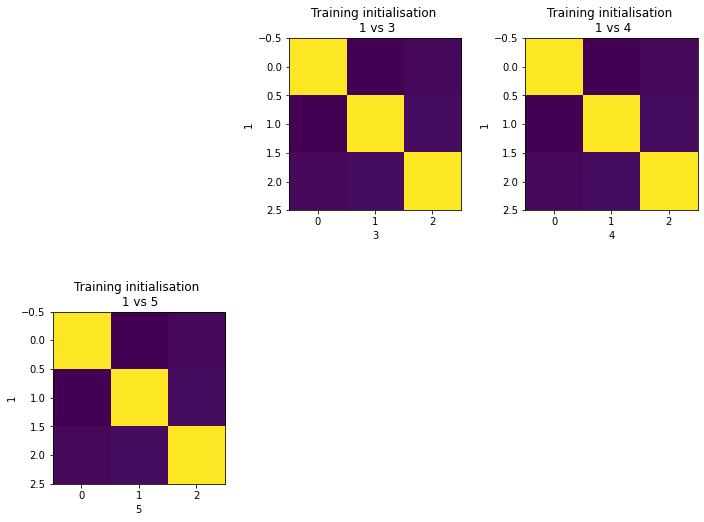

In [23]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

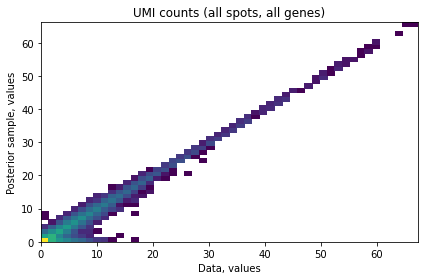

In [24]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [25]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

Trying to set attribute `.obs` of view, copying.


top-1  \
mean_cell_type_factorsfact_0  CD19+CD20+ B: 1.0   
mean_cell_type_factorsfact_1  Goblet cells: 1.0   
mean_cell_type_factorsfact_2         CMS2: 0.98   

                                                       top-2  \
mean_cell_type_factorsfact_0              CD8+ T cells: 0.99   
mean_cell_type_factorsfact_1  Mature Enterocytes type 1: 1.0   
mean_cell_type_factorsfact_2                 Stromal 3: 0.96   

                                                        top-3  \
mean_cell_type_factorsfact_0                       CMS1: 0.96   
mean_cell_type_factorsfact_1  Mature Enterocytes type 2: 0.98   
mean_cell_type_factorsfact_2             Myofibroblasts: 0.94   

                                          top-4                     top-5  \
mean_cell_type_factorsfact_0     NK cells: 0.86               SPP1+: 0.69   
mean_cell_type_factorsfact_1         CMS3: 0.94         Stem-like/TA: 0.9   
mean_cell_type_factorsfact_2  IgG+ Plasma: 0.93  Smooth muscle cells: 0.9   

                                          top-6               top-7  \
mean_cell_type_factorsfact_0          cDC: 0.61        Unknown: 0.5   
mean_cell_type_factorsfact_1  IgA+ Plasma: 0.84  Intermediate: 0.77   
mean_cell_type_factorsfact_2    Stromal 2: 0.84     Pericytes: 0.79   

                                                  top-8  \
mean_cell_type_factorsfact_0  gamma delta T cells: 0.48   
mean_cell_type_factorsfact_1            Stromal 1: 0.44   
mean_cell_type_factorsfact_2        Lymphatic ECs: 0.78   

                                                        top-9  
mean_cell_type_factorsfact_0  T follicular helper cells: 0.43  
mean_cell_type_factorsfact_1                 Mast cells: 0.22  
mean_cell_type_factorsfact_2        Enteric glial cells: 0.75

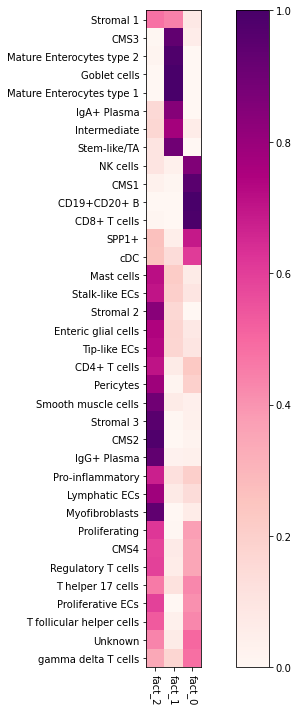

In [26]:
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

In [27]:
mod_sk.cell_type_fractions.to_csv(path_or_buf="Cell2Location/results/colocalizationFactors/R3.csv")

### R = 4

In [28]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(4)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 6998
init_2 - iterations until convergence: 6865
init_3 - iterations until convergence: 7579
init_4 - iterations until convergence: 6618
init_5 - iterations until convergence: 6025


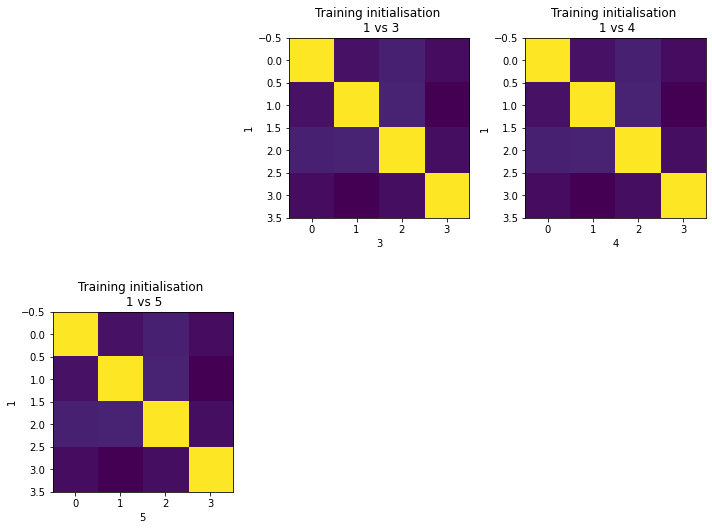

In [29]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

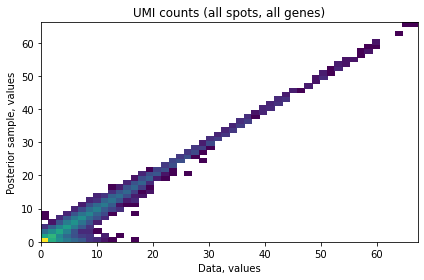

In [30]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [31]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0  Mature Enterocytes type 2: 0.98   
mean_cell_type_factorsfact_1               CD19+CD20+ B: 0.99   
mean_cell_type_factorsfact_2                       CMS2: 0.98   
mean_cell_type_factorsfact_3                   Stromal 3: 1.0   

                                                        top-2  \
mean_cell_type_factorsfact_0  Mature Enterocytes type 1: 0.97   
mean_cell_type_factorsfact_1                       CMS1: 0.94   
mean_cell_type_factorsfact_2                  Stromal 2: 0.44   
mean_cell_type_factorsfact_3                 IgG+ Plasma: 1.0   

                                                  top-3  \
mean_cell_type_factorsfact_0         Goblet cells: 0.97   
mean_cell_type_factorsfact_1         CD8+ T cells: 0.93   
mean_cell_type_factorsfact_2     Pro-inflammatory: 0.41   
mean_cell_type_factorsfact_3  Smooth muscle cells: 0.99   

                                               top-4                 top-5  \
mean_cell_type_factorsfact_0              CMS3: 0.89    Stem-like/TA: 0.89   
mean_cell_type_factorsfact_1          NK cells: 0.67             cDC: 0.32   
mean_cell_type_factorsfact_2  Proliferative ECs: 0.4    Proliferating: 0.4   
mean_cell_type_factorsfact_3    Myofibroblasts: 0.99  Stalk-like ECs: 0.96   

                                          top-6                      top-7  \
mean_cell_type_factorsfact_0  IgA+ Plasma: 0.66         Intermediate: 0.63   
mean_cell_type_factorsfact_1        SPP1+: 0.31    Proliferative ECs: 0.31   
mean_cell_type_factorsfact_2         CMS4: 0.26            Pericytes: 0.21   
mean_cell_type_factorsfact_3   Mast cells: 0.95  Enteric glial cells: 0.93   

                                                        top-8  \
mean_cell_type_factorsfact_0                  Stromal 1: 0.18   
mean_cell_type_factorsfact_1        gamma delta T cells: 0.28   
mean_cell_type_factorsfact_2  T follicular helper cells: 0.15   
mean_cell_type_factorsfact_3              Lymphatic ECs: 0.91   

                                                   top-9  
mean_cell_type_factorsfact_0  gamma delta T cells: 0.098  
mean_cell_type_factorsfact_1         Proliferating: 0.27  
mean_cell_type_factorsfact_2          CD4+ T cells: 0.13  
mean_cell_type_factorsfact_3           Tip-like ECs: 0.8

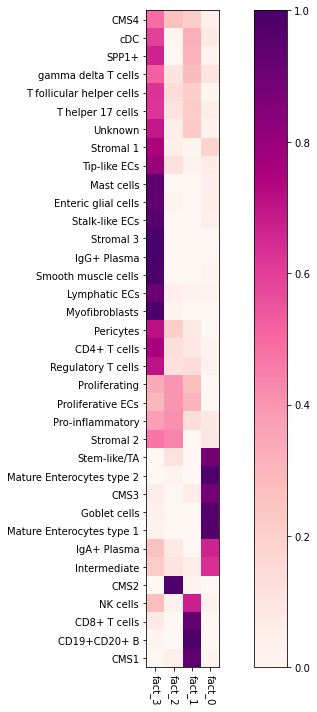

In [32]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 5

In [33]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(5)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 6517
init_2 - iterations until convergence: 6568
init_3 - iterations until convergence: 6693
init_4 - iterations until convergence: 7243
init_5 - iterations until convergence: 5590


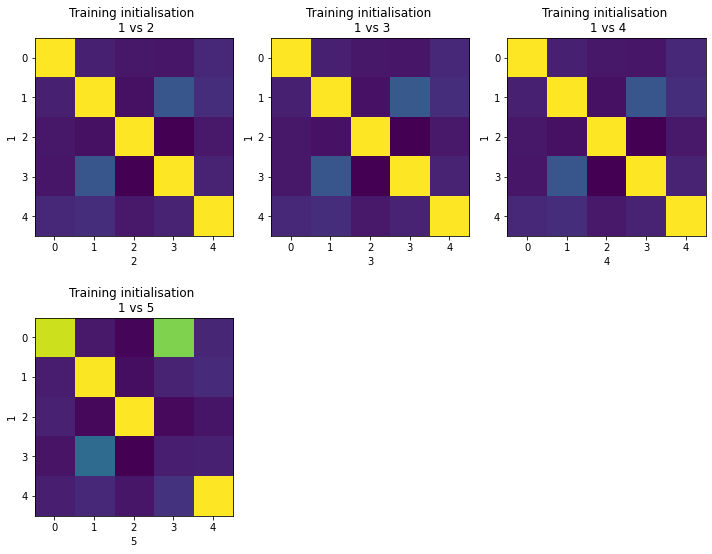

In [34]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

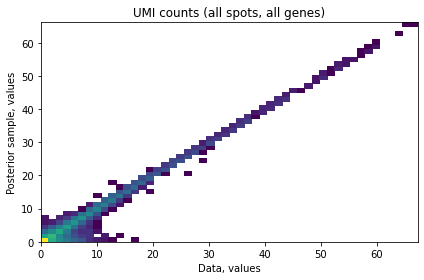

In [35]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [36]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0  Mature Enterocytes type 2: 0.98   
mean_cell_type_factorsfact_1                       CMS2: 0.96   
mean_cell_type_factorsfact_2                   Stromal 3: 1.0   
mean_cell_type_factorsfact_3                       CMS1: 0.98   
mean_cell_type_factorsfact_4               CD8+ T cells: 0.98   

                                                        top-2  \
mean_cell_type_factorsfact_0  Mature Enterocytes type 1: 0.97   
mean_cell_type_factorsfact_1                  Stromal 2: 0.44   
mean_cell_type_factorsfact_2                 IgG+ Plasma: 1.0   
mean_cell_type_factorsfact_3               CD19+CD20+ B: 0.53   
mean_cell_type_factorsfact_4                   NK cells: 0.75   

                                                  top-3  \
mean_cell_type_factorsfact_0         Goblet cells: 0.97   
mean_cell_type_factorsfact_1     Pro-inflammatory: 0.38   
mean_cell_type_factorsfact_2  Smooth muscle cells: 0.99   
mean_cell_type_factorsfact_3                 CMS3: 0.17   
mean_cell_type_factorsfact_4         CD19+CD20+ B: 0.47   

                                                top-4                 top-5  \
mean_cell_type_factorsfact_0       Stem-like/TA: 0.87            CMS3: 0.78   
mean_cell_type_factorsfact_1  Proliferative ECs: 0.37   Proliferating: 0.37   
mean_cell_type_factorsfact_2     Myofibroblasts: 0.98  Stalk-like ECs: 0.95   
mean_cell_type_factorsfact_3   Pro-inflammatory: 0.14            CMS4: 0.12   
mean_cell_type_factorsfact_4  Proliferative ECs: 0.39           SPP1+: 0.39   

                                            top-6                      top-7  \
mean_cell_type_factorsfact_0    IgA+ Plasma: 0.65         Intermediate: 0.61   
mean_cell_type_factorsfact_1           CMS4: 0.24             Pericytes: 0.2   
mean_cell_type_factorsfact_2     Mast cells: 0.94  Enteric glial cells: 0.91   
mean_cell_type_factorsfact_3       Unknown: 0.092                  cDC: 0.07   
mean_cell_type_factorsfact_4  Proliferating: 0.35  gamma delta T cells: 0.35   

                                                        top-8  \
mean_cell_type_factorsfact_0                  Stromal 1: 0.17   
mean_cell_type_factorsfact_1  T follicular helper cells: 0.14   
mean_cell_type_factorsfact_2               Lymphatic ECs: 0.9   
mean_cell_type_factorsfact_3                       CMS2: 0.04   
mean_cell_type_factorsfact_4                        cDC: 0.33   

                                                   top-9  
mean_cell_type_factorsfact_0            Stromal 2: 0.091  
mean_cell_type_factorsfact_1          CD4+ T cells: 0.13  
mean_cell_type_factorsfact_2          Tip-like ECs: 0.79  
mean_cell_type_factorsfact_3  Enteric glial cells: 0.031  
mean_cell_type_factorsfact_4     T helper 17 cells: 0.27

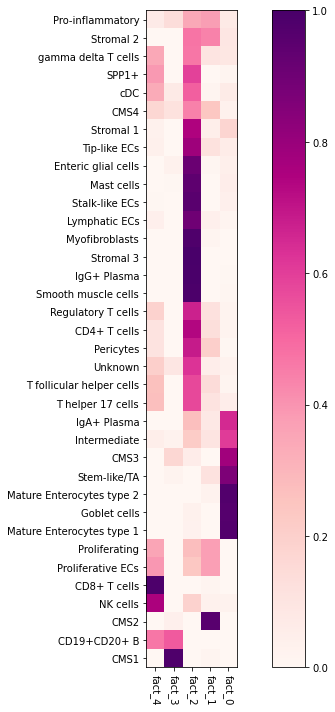

In [37]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

Trying to set attribute `.uns` of view, copying.


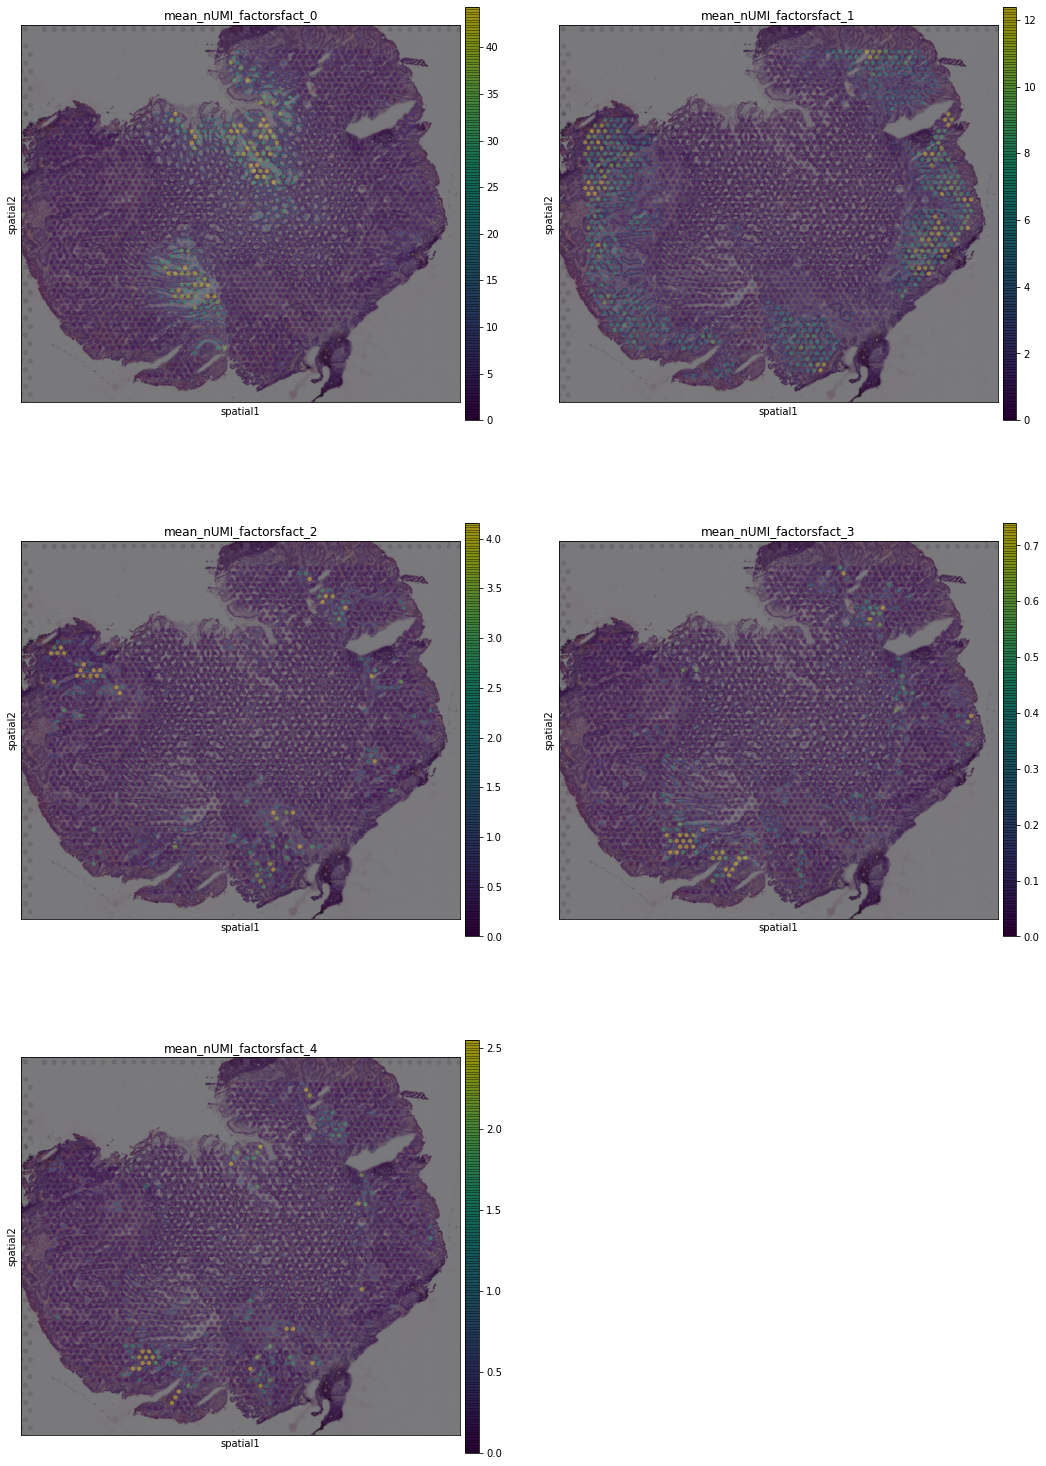

In [38]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (8, 8), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'Count_SN048_A121573_Rep2')

    sc.pl.spatial(slide,
                  cmap='viridis',
                  color=mod_sk.location_factors_df.columns,
                  size=1, img_key='hires',
                  alpha_img=0.5, alpha = 0.4, ncols=2,
                  vmin=0, vmax='p99.2'
                 )

Trying to set attribute `.uns` of view, copying.


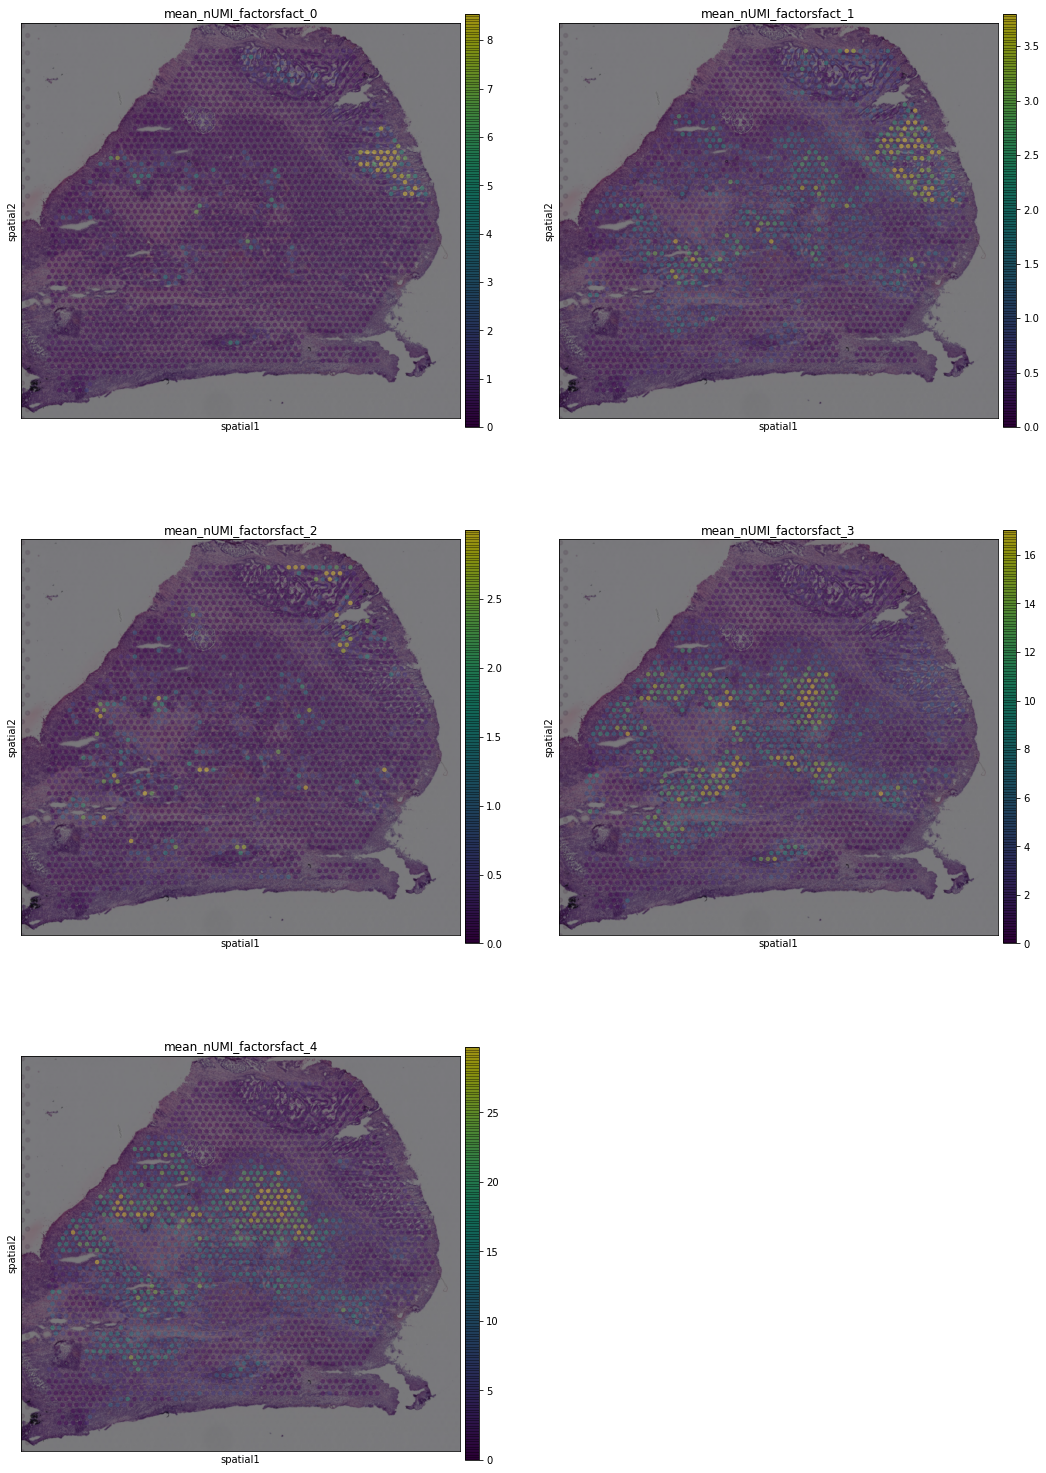

In [39]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (8, 8), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'Count_SN048_A416371_Rep1')

    sc.pl.spatial(slide,
                  cmap='viridis',
                  color=mod_sk.location_factors_df.columns,
                  size=1, img_key='hires',
                  alpha_img=0.5, alpha = 0.4, ncols=2,
                  vmin=0, vmax='p99.2'
                 )

### R = 6

In [40]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(6)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 6352
init_2 - iterations until convergence: 5754
init_3 - iterations until convergence: 5819
init_4 - iterations until convergence: 6170
init_5 - iterations until convergence: 5410


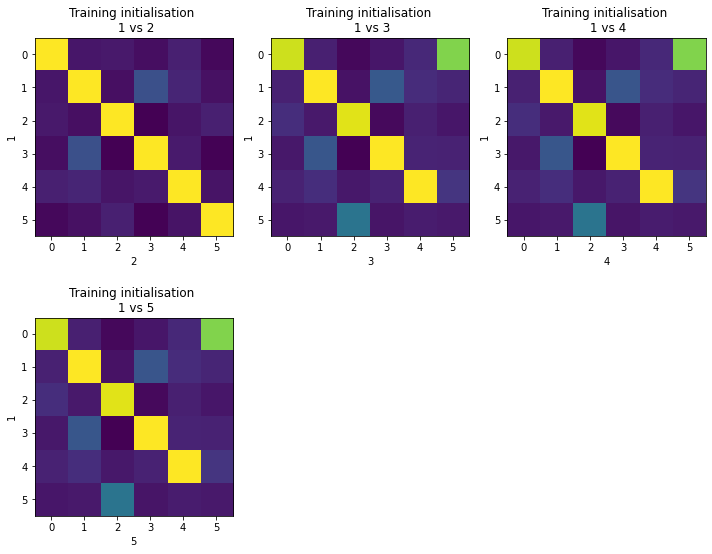

In [41]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

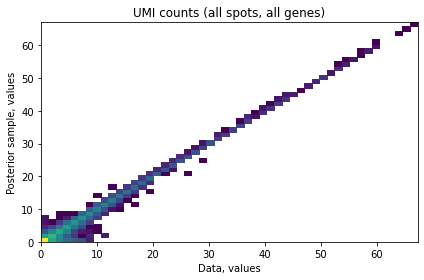

In [42]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [43]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0              CD8+ T cells: 0.98   
mean_cell_type_factorsfact_1  Mature Enterocytes type 1: 0.9   
mean_cell_type_factorsfact_2              Stem-like/TA: 0.98   
mean_cell_type_factorsfact_3                      CMS2: 0.96   
mean_cell_type_factorsfact_4                 Stromal 3: 0.99   
mean_cell_type_factorsfact_5                      CMS1: 0.97   

                                                       top-2  \
mean_cell_type_factorsfact_0                  NK cells: 0.75   
mean_cell_type_factorsfact_1  Mature Enterocytes type 2: 0.9   
mean_cell_type_factorsfact_2              Goblet cells: 0.91   
mean_cell_type_factorsfact_3                 Stromal 2: 0.43   
mean_cell_type_factorsfact_4            Myofibroblasts: 0.98   
mean_cell_type_factorsfact_5              CD19+CD20+ B: 0.52   

                                               top-3  \
mean_cell_type_factorsfact_0      CD19+CD20+ B: 0.48   
mean_cell_type_factorsfact_1       IgA+ Plasma: 0.41   
mean_cell_type_factorsfact_2              CMS3: 0.73   
mean_cell_type_factorsfact_3     Proliferating: 0.37   
mean_cell_type_factorsfact_4       IgG+ Plasma: 0.97   
mean_cell_type_factorsfact_5  Pro-inflammatory: 0.13   

                                                  top-4  \
mean_cell_type_factorsfact_0                SPP1+: 0.39   
mean_cell_type_factorsfact_1         Intermediate: 0.36   
mean_cell_type_factorsfact_2         Intermediate: 0.37   
mean_cell_type_factorsfact_3     Pro-inflammatory: 0.37   
mean_cell_type_factorsfact_4  Smooth muscle cells: 0.92   
mean_cell_type_factorsfact_5                 CMS4: 0.11   

                                                top-5                 top-6  \
mean_cell_type_factorsfact_0  Proliferative ECs: 0.39   Proliferating: 0.36   
mean_cell_type_factorsfact_1                CMS3: 0.2        Stromal 1: 0.1   
mean_cell_type_factorsfact_2        IgA+ Plasma: 0.35       Stromal 1: 0.23   
mean_cell_type_factorsfact_3  Proliferative ECs: 0.37            CMS4: 0.24   
mean_cell_type_factorsfact_4         Mast cells: 0.88  Stalk-like ECs: 0.87   
mean_cell_type_factorsfact_5           Unknown: 0.088            cDC: 0.067   

                                                  top-7  \
mean_cell_type_factorsfact_0  gamma delta T cells: 0.34   
mean_cell_type_factorsfact_1        Goblet cells: 0.093   
mean_cell_type_factorsfact_2       Stalk-like ECs: 0.11   
mean_cell_type_factorsfact_3             Pericytes: 0.2   
mean_cell_type_factorsfact_4        Lymphatic ECs: 0.84   
mean_cell_type_factorsfact_5                CMS3: 0.065   

                                                        top-8  \
mean_cell_type_factorsfact_0                        cDC: 0.33   
mean_cell_type_factorsfact_1                 Stromal 2: 0.086   
mean_cell_type_factorsfact_2         Enteric glial cells: 0.1   
mean_cell_type_factorsfact_3  T follicular helper cells: 0.14   
mean_cell_type_factorsfact_4        Enteric glial cells: 0.84   
mean_cell_type_factorsfact_5                      CMS2: 0.039   

                                                         top-9  
mean_cell_type_factorsfact_0           T helper 17 cells: 0.26  
mean_cell_type_factorsfact_1         gamma delta T cells: 0.08  
mean_cell_type_factorsfact_2  Mature Enterocytes type 2: 0.085  
mean_cell_type_factorsfact_3                CD4+ T cells: 0.13  
mean_cell_type_factorsfact_4                Tip-like ECs: 0.76  
mean_cell_type_factorsfact_5        Enteric glial cells: 0.028

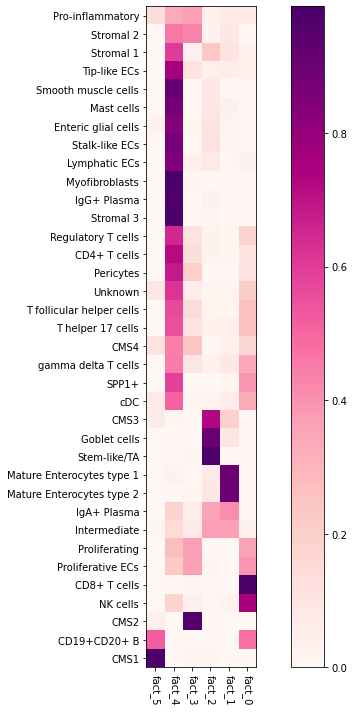

In [44]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 7

In [45]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(7)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 5190
init_2 - iterations until convergence: 3886
init_3 - iterations until convergence: 5731
init_4 - iterations until convergence: 4307
init_5 - iterations until convergence: 5086


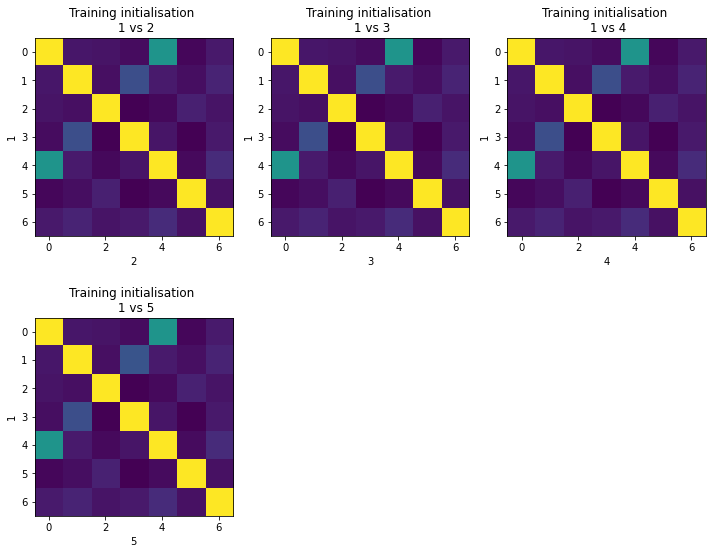

In [46]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

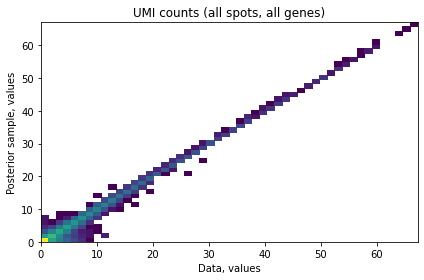

In [47]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [48]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                       CMS1: 0.97   
mean_cell_type_factorsfact_1               Stem-like/TA: 0.98   
mean_cell_type_factorsfact_2         Smooth muscle cells: 1.0   
mean_cell_type_factorsfact_3               CD8+ T cells: 0.98   
mean_cell_type_factorsfact_4  Mature Enterocytes type 1: 0.88   
mean_cell_type_factorsfact_5                       CMS2: 0.96   
mean_cell_type_factorsfact_6              Myofibroblasts: 1.0   

                                                        top-2  \
mean_cell_type_factorsfact_0               CD19+CD20+ B: 0.53   
mean_cell_type_factorsfact_1               Goblet cells: 0.91   
mean_cell_type_factorsfact_2                   Stromal 3: 0.8   
mean_cell_type_factorsfact_3                   NK cells: 0.71   
mean_cell_type_factorsfact_4  Mature Enterocytes type 2: 0.88   
mean_cell_type_factorsfact_5                  Stromal 2: 0.38   
mean_cell_type_factorsfact_6                      SPP1+: 0.56   

                                                top-3  \
mean_cell_type_factorsfact_0   Pro-inflammatory: 0.12   
mean_cell_type_factorsfact_1               CMS3: 0.71   
mean_cell_type_factorsfact_2     Stalk-like ECs: 0.73   
mean_cell_type_factorsfact_3       CD19+CD20+ B: 0.46   
mean_cell_type_factorsfact_4        IgA+ Plasma: 0.35   
mean_cell_type_factorsfact_5  Proliferative ECs: 0.35   
mean_cell_type_factorsfact_6       CD4+ T cells: 0.48   

                                                 top-4  \
mean_cell_type_factorsfact_0                CMS4: 0.11   
mean_cell_type_factorsfact_1        Intermediate: 0.36   
mean_cell_type_factorsfact_2         IgG+ Plasma: 0.64   
mean_cell_type_factorsfact_3   Proliferative ECs: 0.37   
mean_cell_type_factorsfact_4        Intermediate: 0.33   
mean_cell_type_factorsfact_5       Proliferating: 0.34   
mean_cell_type_factorsfact_6  Regulatory T cells: 0.47   

                                                  top-5                top-6  \
mean_cell_type_factorsfact_0             Unknown: 0.076          CMS3: 0.063   
mean_cell_type_factorsfact_1          IgA+ Plasma: 0.31      Stromal 1: 0.18   
mean_cell_type_factorsfact_2  Enteric glial cells: 0.57  Lymphatic ECs: 0.56   
mean_cell_type_factorsfact_3                SPP1+: 0.36  Proliferating: 0.32   
mean_cell_type_factorsfact_4                 CMS3: 0.18  Goblet cells: 0.087   
mean_cell_type_factorsfact_5     Pro-inflammatory: 0.34           CMS4: 0.21   
mean_cell_type_factorsfact_6              Unknown: 0.45      Pericytes: 0.44   

                                                       top-7  \
mean_cell_type_factorsfact_0                      cDC: 0.058   
mean_cell_type_factorsfact_1  Mature Enterocytes type 2: 0.1   
mean_cell_type_factorsfact_2                Mast cells: 0.49   
mean_cell_type_factorsfact_3        gamma delta T cells: 0.3   
mean_cell_type_factorsfact_4                Stromal 1: 0.077   
mean_cell_type_factorsfact_5                 Pericytes: 0.16   
mean_cell_type_factorsfact_6                Mast cells: 0.44   

                                                         top-8  \
mean_cell_type_factorsfact_0                       CMS2: 0.041   
mean_cell_type_factorsfact_1  Mature Enterocytes type 1: 0.091   
mean_cell_type_factorsfact_2                Tip-like ECs: 0.46   
mean_cell_type_factorsfact_3                         cDC: 0.28   
mean_cell_type_factorsfact_4                  Stromal 2: 0.073   
mean_cell_type_factorsfact_5   T follicular helper cells: 0.12   
mean_cell_type_factorsfact_6           T helper 17 cells: 0.41   

                                                       top-9  
mean_cell_type_factorsfact_0      Enteric glial cells: 0.019  
mean_cell_type_factorsfact_1      Enteric glial cells: 0.049  
mean_cell_type_factorsfact_2                 Stromal 1: 0.34  
mean_cell_type_factorsfact_3         T helper 17 cells: 0.22  
mean_cell_type_factorsfact_4       gamma delta T cells: 0.07  
mean_cell_type_factorsfact_5   

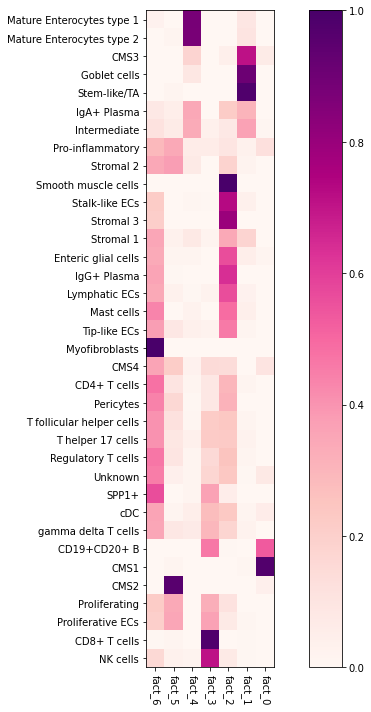

In [49]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

In [50]:
mod_sk.cell_type_fractions.to_csv(path_or_buf="Cell2Location/results/colocalizationFactors/R7.csv")

Trying to set attribute `.uns` of view, copying.


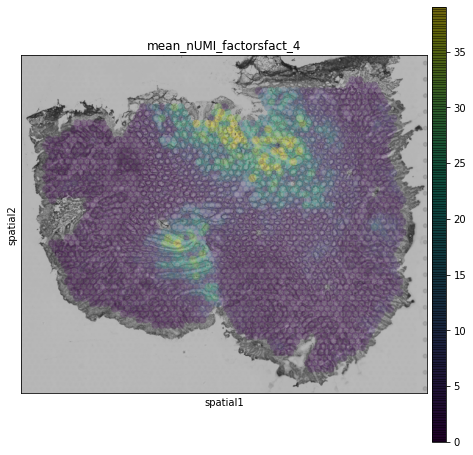

In [51]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (8, 8), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data
    slide = select_slide(adata_vis, 'Count_SN048_A121573_Rep1')

    sc.pl.spatial(slide,
                  cmap='viridis',
                  color='mean_nUMI_factorsfact_4',
                  size=2, img_key='hires',
                  alpha_img=0.75, alpha = 0.25,
                  vmin=0, vmax='p99.2', bw = True 
                 )

### R = 8

In [52]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(8)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 5513
init_2 - iterations until convergence: 5062
init_3 - iterations until convergence: 4198
init_4 - iterations until convergence: 4763
init_5 - iterations until convergence: 4771


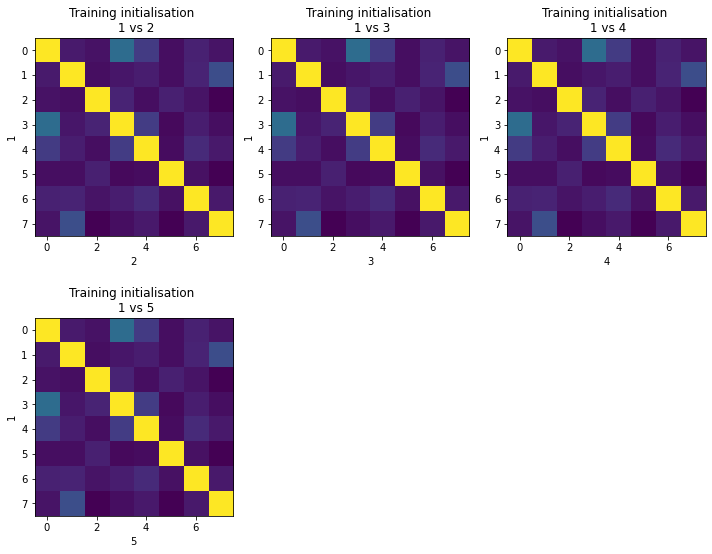

In [53]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

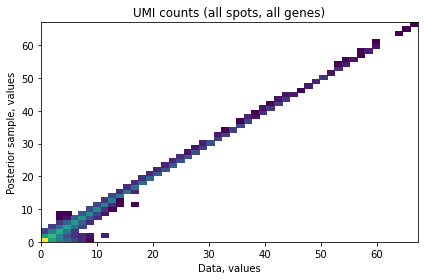

In [54]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [55]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0  Mature Enterocytes type 1: 0.89   
mean_cell_type_factorsfact_1               CD19+CD20+ B: 0.95   
mean_cell_type_factorsfact_2              Myofibroblasts: 1.0   
mean_cell_type_factorsfact_3                       CMS2: 0.95   
mean_cell_type_factorsfact_4               CD8+ T cells: 0.63   
mean_cell_type_factorsfact_5         Smooth muscle cells: 1.0   
mean_cell_type_factorsfact_6                       CMS1: 0.91   
mean_cell_type_factorsfact_7               Stem-like/TA: 0.97   

                                                        top-2  \
mean_cell_type_factorsfact_0  Mature Enterocytes type 2: 0.89   
mean_cell_type_factorsfact_1               CD8+ T cells: 0.32   
mean_cell_type_factorsfact_2               CD4+ T cells: 0.46   
mean_cell_type_factorsfact_3                  Stromal 2: 0.38   
mean_cell_type_factorsfact_4          Proliferative ECs: 0.53   
mean_cell_type_factorsfact_5                   Stromal 3: 0.8   
mean_cell_type_factorsfact_6           Pro-inflammatory: 0.24   
mean_cell_type_factorsfact_7               Goblet cells: 0.91   

                                                 top-3  \
mean_cell_type_factorsfact_0         IgA+ Plasma: 0.34   
mean_cell_type_factorsfact_1            NK cells: 0.23   
mean_cell_type_factorsfact_2  Regulatory T cells: 0.44   
mean_cell_type_factorsfact_3    Pro-inflammatory: 0.29   
mean_cell_type_factorsfact_4               SPP1+: 0.51   
mean_cell_type_factorsfact_5      Stalk-like ECs: 0.72   
mean_cell_type_factorsfact_6             Unknown: 0.19   
mean_cell_type_factorsfact_7                CMS3: 0.63   

                                                top-4  \
mean_cell_type_factorsfact_0       Intermediate: 0.33   
mean_cell_type_factorsfact_1                 cDC: 0.2   
mean_cell_type_factorsfact_2         Mast cells: 0.44   
mean_cell_type_factorsfact_3  Proliferative ECs: 0.27   
mean_cell_type_factorsfact_4           NK cells: 0.51   
mean_cell_type_factorsfact_5        IgG+ Plasma: 0.64   
mean_cell_type_factorsfact_6               CMS3: 0.16   
mean_cell_type_factorsfact_7       Intermediate: 0.35   

                                                  top-5  \
mean_cell_type_factorsfact_0                 CMS3: 0.16   
mean_cell_type_factorsfact_1  gamma delta T cells: 0.11   
mean_cell_type_factorsfact_2                SPP1+: 0.42   
mean_cell_type_factorsfact_3        Proliferating: 0.27   
mean_cell_type_factorsfact_4        Proliferating: 0.49   
mean_cell_type_factorsfact_5  Enteric glial cells: 0.56   
mean_cell_type_factorsfact_6                 CMS4: 0.09   
mean_cell_type_factorsfact_7          IgA+ Plasma: 0.29   

                                                        top-6  \
mean_cell_type_factorsfact_0              Goblet cells: 0.088   
mean_cell_type_factorsfact_1  T follicular helper cells: 0.11   
mean_cell_type_factorsfact_2                   Pericytes: 0.4   
mean_cell_type_factorsfact_3                        CMS4: 0.2   
mean_cell_type_factorsfact_4        gamma delta T cells: 0.25   
mean_cell_type_factorsfact_5              Lymphatic ECs: 0.55   
mean_cell_type_factorsfact_6              CD8+ T cells: 0.052   
mean_cell_type_factorsfact_7                  Stromal 1: 0.17   

                                                         top-7  \
mean_cell_type_factorsfact_0                  Stromal 1: 0.075   
mean_cell_type_factorsfact_1          T helper 17 cells: 0.098   
mean_cell_type_factorsfact_2   T follicular helper cells: 0.38   
mean_cell_type_factorsfact_3                   Pericytes: 0.15   
mean_cell_type_factorsfact_4                     Unknown: 0.19   
mean_cell_type_factorsfact_5                  Mast cells: 0.49   
mean_cell_type_factorsfact_6                   NK cells: 0.049   
mean_cell_type_factorsfact_7  Mature Enterocytes type 2: 0.088   

                                                         top-8  \
mean_cell_type_factorsfact_0                  Stromal 2: 0.072   
me

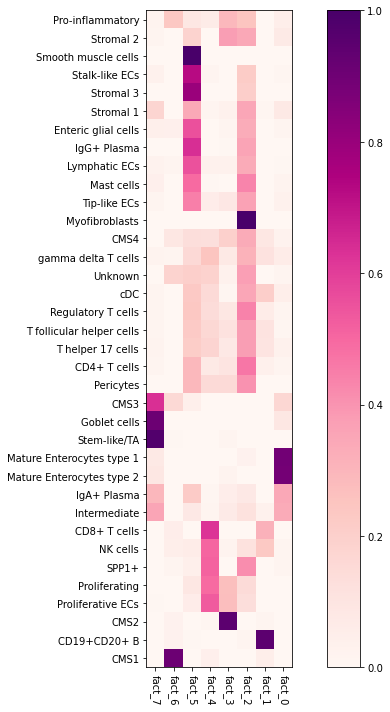

In [56]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 9

In [57]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(9)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 5127
init_2 - iterations until convergence: 4356
init_3 - iterations until convergence: 3996
init_4 - iterations until convergence: 4112
init_5 - iterations until convergence: 4970


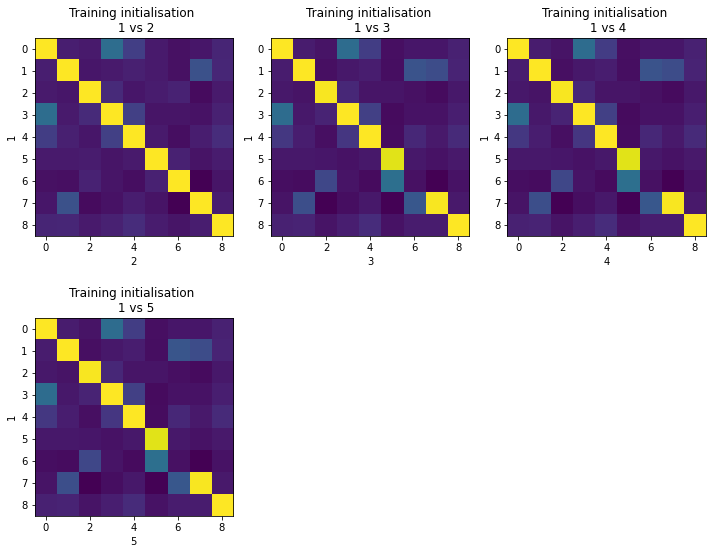

In [58]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

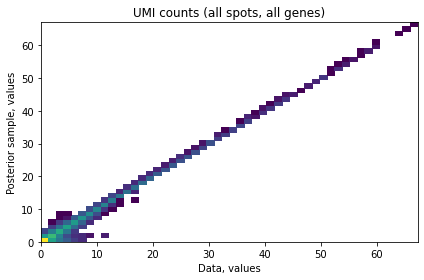

In [59]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [60]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                       CMS3: 0.93   
mean_cell_type_factorsfact_1               CD19+CD20+ B: 0.94   
mean_cell_type_factorsfact_2  Mature Enterocytes type 1: 0.88   
mean_cell_type_factorsfact_3              Myofibroblasts: 1.0   
mean_cell_type_factorsfact_4         Smooth muscle cells: 1.0   
mean_cell_type_factorsfact_5                       CMS2: 0.94   
mean_cell_type_factorsfact_6               CD8+ T cells: 0.62   
mean_cell_type_factorsfact_7               Stem-like/TA: 0.92   
mean_cell_type_factorsfact_8                       CMS1: 0.95   

                                                        top-2  \
mean_cell_type_factorsfact_0                IgA+ Plasma: 0.51   
mean_cell_type_factorsfact_1               CD8+ T cells: 0.31   
mean_cell_type_factorsfact_2  Mature Enterocytes type 2: 0.83   
mean_cell_type_factorsfact_3               CD4+ T cells: 0.45   
mean_cell_type_factorsfact_4                   Stromal 3: 0.8   
mean_cell_type_factorsfact_5                  Stromal 2: 0.34   
mean_cell_type_factorsfact_6                      SPP1+: 0.51   
mean_cell_type_factorsfact_7                Goblet cells: 0.9   
mean_cell_type_factorsfact_8                    Unknown: 0.18   

                                                 top-3  \
mean_cell_type_factorsfact_0     Pro-inflammatory: 0.3   
mean_cell_type_factorsfact_1            NK cells: 0.23   
mean_cell_type_factorsfact_2        Intermediate: 0.33   
mean_cell_type_factorsfact_3  Regulatory T cells: 0.43   
mean_cell_type_factorsfact_4      Stalk-like ECs: 0.67   
mean_cell_type_factorsfact_5       Proliferating: 0.27   
mean_cell_type_factorsfact_6   Proliferative ECs: 0.51   
mean_cell_type_factorsfact_7        Intermediate: 0.34   
mean_cell_type_factorsfact_8    Pro-inflammatory: 0.15   

                                                  top-4  \
mean_cell_type_factorsfact_0  Enteric glial cells: 0.24   
mean_cell_type_factorsfact_1                   cDC: 0.2   
mean_cell_type_factorsfact_2           IgA+ Plasma: 0.2   
mean_cell_type_factorsfact_3                SPP1+: 0.41   
mean_cell_type_factorsfact_4          IgG+ Plasma: 0.63   
mean_cell_type_factorsfact_5    Proliferative ECs: 0.26   
mean_cell_type_factorsfact_6              NK cells: 0.5   
mean_cell_type_factorsfact_7            Stromal 1: 0.16   
mean_cell_type_factorsfact_8                CMS4: 0.089   

                                                        top-5  \
mean_cell_type_factorsfact_0               Tip-like ECs: 0.15   
mean_cell_type_factorsfact_1        gamma delta T cells: 0.11   
mean_cell_type_factorsfact_2               Goblet cells: 0.09   
mean_cell_type_factorsfact_3                 Mast cells: 0.41   
mean_cell_type_factorsfact_4              Lymphatic ECs: 0.52   
mean_cell_type_factorsfact_5           Pro-inflammatory: 0.22   
mean_cell_type_factorsfact_6              Proliferating: 0.49   
mean_cell_type_factorsfact_7  Mature Enterocytes type 1: 0.09   
mean_cell_type_factorsfact_8              CD8+ T cells: 0.059   

                                                       top-6  \
mean_cell_type_factorsfact_0                 Stromal 2: 0.14   
mean_cell_type_factorsfact_1  T follicular helper cells: 0.1   
mean_cell_type_factorsfact_2                Stromal 1: 0.072   
mean_cell_type_factorsfact_3                 Pericytes: 0.38   
mean_cell_type_factorsfact_4                Mast cells: 0.46   
mean_cell_type_factorsfact_5                       CMS4: 0.2   
mean_cell_type_factorsfact_6       gamma delta T cells: 0.24   
mean_cell_type_factorsfact_7              IgA+ Plasma: 0.079   
mean_cell_type_factorsfact_8                 NK cells: 0.055   

                                                         top-7  \
mean_cell_type_factorsfact_0               Stalk-like ECs: 0.1   
mean_cell_type_factorsfact_1          T helper 17 cells: 0.095   
mean_cell_type_factorsfact_2         gamma delta T cells: 0.06   
mean_cell_type_factorsfact

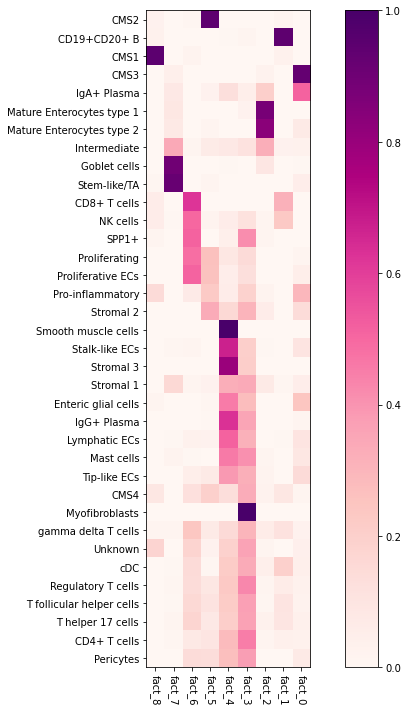

In [61]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 10

In [62]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(10)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 4383
init_2 - iterations until convergence: 4778
init_3 - iterations until convergence: 4217
init_4 - iterations until convergence: 4280
init_5 - iterations until convergence: 3953


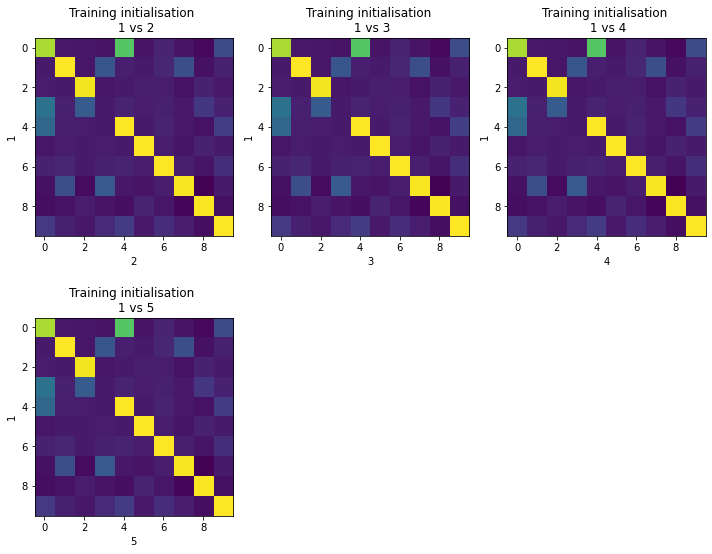

In [63]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

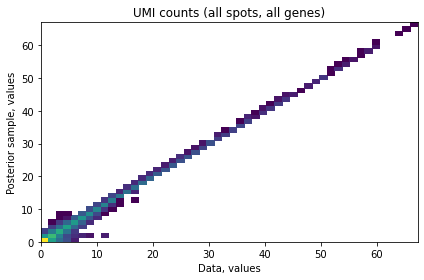

In [64]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [65]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0                 IgG+ Plasma: 1.0   
mean_cell_type_factorsfact_1  Mature Enterocytes type 1: 0.87   
mean_cell_type_factorsfact_2                       CMS3: 0.93   
mean_cell_type_factorsfact_3               CD8+ T cells: 0.64   
mean_cell_type_factorsfact_4               Stem-like/TA: 0.92   
mean_cell_type_factorsfact_5               CD19+CD20+ B: 0.94   
mean_cell_type_factorsfact_6                       CMS2: 0.95   
mean_cell_type_factorsfact_7         Smooth muscle cells: 1.0   
mean_cell_type_factorsfact_8                       CMS1: 0.94   
mean_cell_type_factorsfact_9              Myofibroblasts: 1.0   

                                                        top-2  \
mean_cell_type_factorsfact_0                  Stromal 1: 0.42   
mean_cell_type_factorsfact_1  Mature Enterocytes type 2: 0.83   
mean_cell_type_factorsfact_2                IgA+ Plasma: 0.41   
mean_cell_type_factorsfact_3                    NK cells: 0.5   
mean_cell_type_factorsfact_4                Goblet cells: 0.9   
mean_cell_type_factorsfact_5                CD8+ T cells: 0.3   
mean_cell_type_factorsfact_6                  Stromal 2: 0.29   
mean_cell_type_factorsfact_7                  Stromal 3: 0.54   
mean_cell_type_factorsfact_8                    Unknown: 0.16   
mean_cell_type_factorsfact_9                      SPP1+: 0.36   

                                                top-3  \
mean_cell_type_factorsfact_0     Stalk-like ECs: 0.41   
mean_cell_type_factorsfact_1        Intermediate: 0.3   
mean_cell_type_factorsfact_2   Pro-inflammatory: 0.26   
mean_cell_type_factorsfact_3  Proliferative ECs: 0.49   
mean_cell_type_factorsfact_4       Intermediate: 0.33   
mean_cell_type_factorsfact_5           NK cells: 0.21   
mean_cell_type_factorsfact_6  Proliferative ECs: 0.24   
mean_cell_type_factorsfact_7     Stalk-like ECs: 0.41   
mean_cell_type_factorsfact_8   Pro-inflammatory: 0.14   
mean_cell_type_factorsfact_9       CD4+ T cells: 0.34   

                                                 top-4  \
mean_cell_type_factorsfact_0         Tip-like ECs: 0.4   
mean_cell_type_factorsfact_1         IgA+ Plasma: 0.17   
mean_cell_type_factorsfact_2  Enteric glial cells: 0.2   
mean_cell_type_factorsfact_3               SPP1+: 0.49   
mean_cell_type_factorsfact_4           Stromal 1: 0.13   
mean_cell_type_factorsfact_5                 cDC: 0.17   
mean_cell_type_factorsfact_6       Proliferating: 0.24   
mean_cell_type_factorsfact_7       Lymphatic ECs: 0.33   
mean_cell_type_factorsfact_8               CMS4: 0.083   
mean_cell_type_factorsfact_9  Regulatory T cells: 0.32   

                                                         top-5  \
mean_cell_type_factorsfact_0                   Stromal 2: 0.38   
mean_cell_type_factorsfact_1               Goblet cells: 0.085   
mean_cell_type_factorsfact_2                Tip-like ECs: 0.11   
mean_cell_type_factorsfact_3               Proliferating: 0.46   
mean_cell_type_factorsfact_4  Mature Enterocytes type 1: 0.094   
mean_cell_type_factorsfact_5        gamma delta T cells: 0.099   
mean_cell_type_factorsfact_6            Pro-inflammatory: 0.21   
mean_cell_type_factorsfact_7          Enteric glial cells: 0.3   
mean_cell_type_factorsfact_8               CD8+ T cells: 0.056   
mean_cell_type_factorsfact_9   T follicular helper cells: 0.28   

                                                        top-6  \
mean_cell_type_factorsfact_0                 Mast cells: 0.38   
mean_cell_type_factorsfact_1                 Stromal 1: 0.056   
mean_cell_type_factorsfact_2                 Stromal 2: 0.092   
mean_cell_type_factorsfact_3        gamma delta T cells: 0.23   
mean_cell_type_factorsfact_4  Mature Enterocytes type 2: 0.08   
mean_cell_type_factorsfact_5  T follicular helper cells: 0.09   
mean_cell_type_factorsfact_6                       CMS4: 0.18   
mean_cell_type_factorsfact_7                 Mast cells: 0.25   
mean_cell_type_factorsfact_8                 

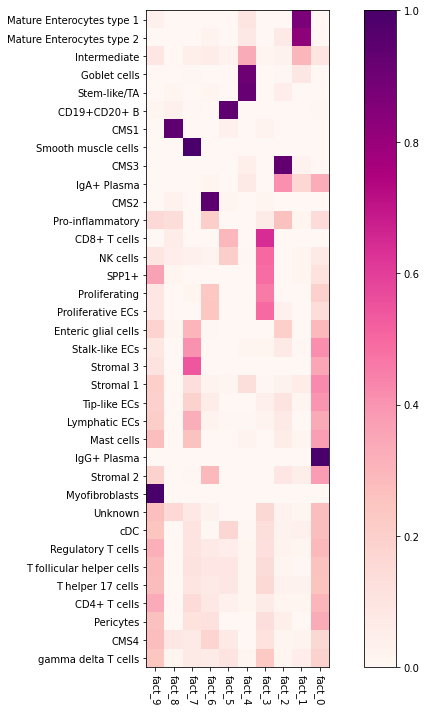

In [66]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 15

In [67]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(15)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 3841
init_2 - iterations until convergence: 3708
init_3 - iterations until convergence: 4075
init_4 - iterations until convergence: 3390
init_5 - iterations until convergence: 3354


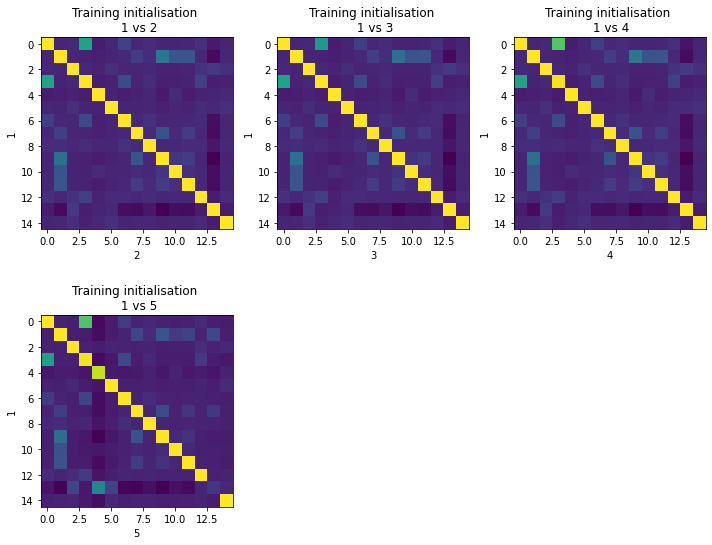

In [68]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

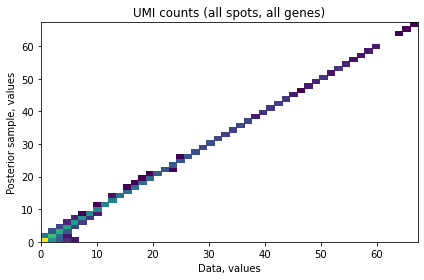

In [69]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [70]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0   Mature Enterocytes type 2: 0.81   
mean_cell_type_factorsfact_1                CD8+ T cells: 0.69   
mean_cell_type_factorsfact_2                CD19+CD20+ B: 0.65   
mean_cell_type_factorsfact_3                        CMS2: 0.95   
mean_cell_type_factorsfact_4   Mature Enterocytes type 1: 0.76   
mean_cell_type_factorsfact_5                Goblet cells: 0.83   
mean_cell_type_factorsfact_6              Myofibroblasts: 0.99   
mean_cell_type_factorsfact_7                   Stromal 2: 0.91   
mean_cell_type_factorsfact_8         Smooth muscle cells: 0.99   
mean_cell_type_factorsfact_9                       SPP1+: 0.85   
mean_cell_type_factorsfact_10                       CMS1: 0.92   
mean_cell_type_factorsfact_11                IgA+ Plasma: 0.98   
mean_cell_type_factorsfact_12                       CMS3: 0.91   
mean_cell_type_factorsfact_13               Stem-like/TA: 0.94   
mean_cell_type_factorsfact_14                 IgG+ Plasma: 1.0   

                                                         top-2  \
mean_cell_type_factorsfact_0   Mature Enterocytes type 1: 0.22   
mean_cell_type_factorsfact_1                    NK cells: 0.45   
mean_cell_type_factorsfact_2                CD8+ T cells: 0.23   
mean_cell_type_factorsfact_3                        CMS4: 0.12   
mean_cell_type_factorsfact_4                Intermediate: 0.16   
mean_cell_type_factorsfact_5                Intermediate: 0.15   
mean_cell_type_factorsfact_6                CD4+ T cells: 0.21   
mean_cell_type_factorsfact_7                   Pericytes: 0.81   
mean_cell_type_factorsfact_8                   Stromal 3: 0.52   
mean_cell_type_factorsfact_9                         cDC: 0.18   
mean_cell_type_factorsfact_10                    Unknown: 0.13   
mean_cell_type_factorsfact_11                  Stromal 1: 0.28   
mean_cell_type_factorsfact_12        Enteric glial cells: 0.16   
mean_cell_type_factorsfact_13               Intermediate: 0.15   
mean_cell_type_factorsfact_14                  Stromal 3: 0.36   

                                                          top-3  \
mean_cell_type_factorsfact_0                  Intermediate: 0.2   
mean_cell_type_factorsfact_1                 CD19+CD20+ B: 0.31   
mean_cell_type_factorsfact_2                     NK cells: 0.14   
mean_cell_type_factorsfact_3                Proliferating: 0.12   
mean_cell_type_factorsfact_4             Pro-inflammatory: 0.16   
mean_cell_type_factorsfact_5   Mature Enterocytes type 2: 0.039   
mean_cell_type_factorsfact_6           Regulatory T cells: 0.19   
mean_cell_type_factorsfact_7            Proliferative ECs: 0.69   
mean_cell_type_factorsfact_8               Stalk-like ECs: 0.32   
mean_cell_type_factorsfact_9                         CMS4: 0.17   
mean_cell_type_factorsfact_10            Pro-inflammatory: 0.11   
mean_cell_type_factorsfact_11              Stalk-like ECs: 0.11   
mean_cell_type_factorsfact_12            Pro-inflammatory: 0.15   
mean_cell_type_factorsfact_13               Goblet cells: 0.081   
mean_cell_type_factorsfact_14              Stalk-like ECs: 0.28   

                                                          top-4  \
mean_cell_type_factorsfact_0                Goblet cells: 0.054   
mean_cell_type_factorsfact_1                Proliferating: 0.26   
mean_cell_type_factorsfact_2                         cDC: 0.094   
mean_cell_type_factorsfact_3             Pro-inflammatory: 0.11   
mean_cell_type_factorsfact_4                    Stromal 1: 0.16   
mean_cell_type_factorsfact_5                        CMS3: 0.036   
mean_cell_type_factorsfact_6                   Mast cells: 0.19   
mean_cell_type_factorsfact_7                 Tip-like ECs: 0.62   
mean_cell_type_factorsfact_8          Enteric glial cells: 0.25   
mean_cell_type_factorsfact_9                     Unknown: 0.076   
mean_cell_type_factorsfact_10                       CMS4: 0.067   
mean_cell_type_factorsfact_11                        cDC: 0.073   

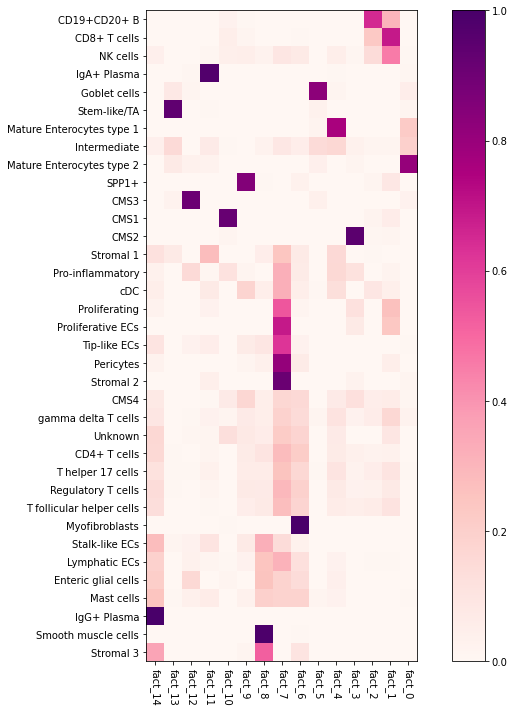

In [71]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])

### R = 20

In [72]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(20)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 3381
init_2 - iterations until convergence: 3593
init_3 - iterations until convergence: 2618
init_4 - iterations until convergence: 2642
init_5 - iterations until convergence: 4732


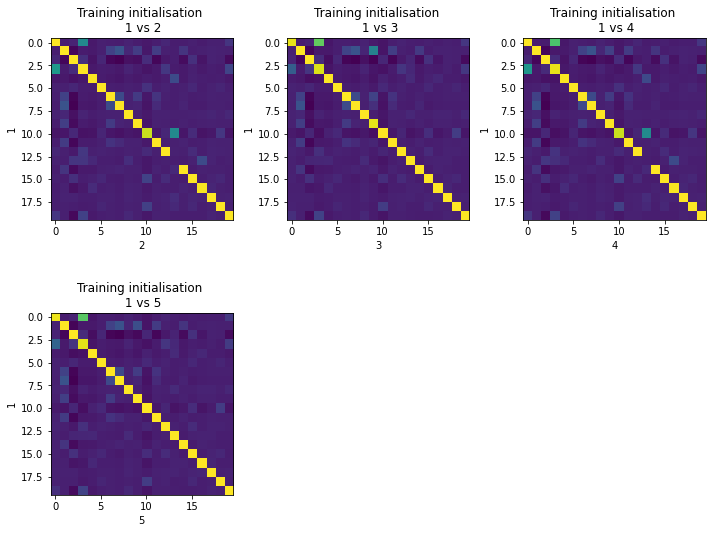

In [73]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

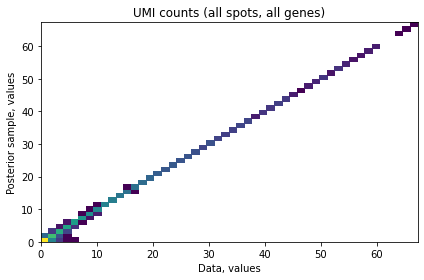

In [74]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [75]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions', top_n = 9)

top-1  \
mean_cell_type_factorsfact_0   Mature Enterocytes type 2: 0.79   
mean_cell_type_factorsfact_1                CD8+ T cells: 0.82   
mean_cell_type_factorsfact_2                CD19+CD20+ B: 0.64   
mean_cell_type_factorsfact_3                 IgG+ Plasma: 0.93   
mean_cell_type_factorsfact_4                Stem-like/TA: 0.94   
mean_cell_type_factorsfact_5   Mature Enterocytes type 1: 0.78   
mean_cell_type_factorsfact_6                 IgA+ Plasma: 0.97   
mean_cell_type_factorsfact_7                         cDC: 0.61   
mean_cell_type_factorsfact_8         Smooth muscle cells: 0.88   
mean_cell_type_factorsfact_9                        CMS3: 0.92   
mean_cell_type_factorsfact_10           Pro-inflammatory: 0.82   
mean_cell_type_factorsfact_11              Proliferating: 0.92   
mean_cell_type_factorsfact_12                  Pericytes: 0.87   
mean_cell_type_factorsfact_13                  Stromal 2: 0.93   
mean_cell_type_factorsfact_14                       CMS1: 0.93   
mean_cell_type_factorsfact_15                      SPP1+: 0.83   
mean_cell_type_factorsfact_16                  Stromal 3: 0.86   
mean_cell_type_factorsfact_17                       CMS2: 0.95   
mean_cell_type_factorsfact_18             Myofibroblasts: 0.91   
mean_cell_type_factorsfact_19               Goblet cells: 0.81   

                                                         top-2  \
mean_cell_type_factorsfact_0   Mature Enterocytes type 1: 0.19   
mean_cell_type_factorsfact_1                     NK cells: 0.5   
mean_cell_type_factorsfact_2                         cDC: 0.11   
mean_cell_type_factorsfact_3                 Mast cells: 0.077   
mean_cell_type_factorsfact_4                Intermediate: 0.14   
mean_cell_type_factorsfact_5                Intermediate: 0.15   
mean_cell_type_factorsfact_6                   Stromal 1: 0.24   
mean_cell_type_factorsfact_7           Regulatory T cells: 0.6   
mean_cell_type_factorsfact_8              Lymphatic ECs: 0.091   
mean_cell_type_factorsfact_9         Enteric glial cells: 0.12   
mean_cell_type_factorsfact_10         Proliferative ECs: 0.089   
mean_cell_type_factorsfact_11          Proliferative ECs: 0.17   
mean_cell_type_factorsfact_12                Tip-like ECs: 0.7   
mean_cell_type_factorsfact_13                 Stromal 1: 0.082   
mean_cell_type_factorsfact_14                    Unknown: 0.11   
mean_cell_type_factorsfact_15                       CMS4: 0.14   
mean_cell_type_factorsfact_16             Stalk-like ECs: 0.65   
mean_cell_type_factorsfact_17                       CMS4: 0.12   
mean_cell_type_factorsfact_18               CD4+ T cells: 0.11   
mean_cell_type_factorsfact_19               Intermediate: 0.14   

                                                          top-3  \
mean_cell_type_factorsfact_0                 Intermediate: 0.18   
mean_cell_type_factorsfact_1                  CD19+CD20+ B: 0.3   
mean_cell_type_factorsfact_2                CD8+ T cells: 0.044   
mean_cell_type_factorsfact_3                     Unknown: 0.076   
mean_cell_type_factorsfact_4                Goblet cells: 0.079   
mean_cell_type_factorsfact_5                     Stromal 1: 0.1   
mean_cell_type_factorsfact_6              Stalk-like ECs: 0.058   
mean_cell_type_factorsfact_7                Lymphatic ECs: 0.57   
mean_cell_type_factorsfact_8                   Stromal 3: 0.077   
mean_cell_type_factorsfact_9    Mature Enterocytes type 2: 0.03   
mean_cell_type_factorsfact_10             Stalk-like ECs: 0.056   
mean_cell_type_factorsfact_11  T follicular helper cells: 0.046   
mean_cell_type_factorsfact_12           Proliferative ECs: 0.56   
mean_cell_type_factorsfact_13                         cDC: 0.07   
mean_cell_type_factorsfact_14                       CMS4: 0.071   
mean_cell_type_factorsfact_15                         cDC: 0.11   
mean_cell_type_factorsfact_16         Enteric glial cells: 0.38   
mean_cell_type_factorsfact_17  T follicular helper cells: 0.047   
mean_cell_

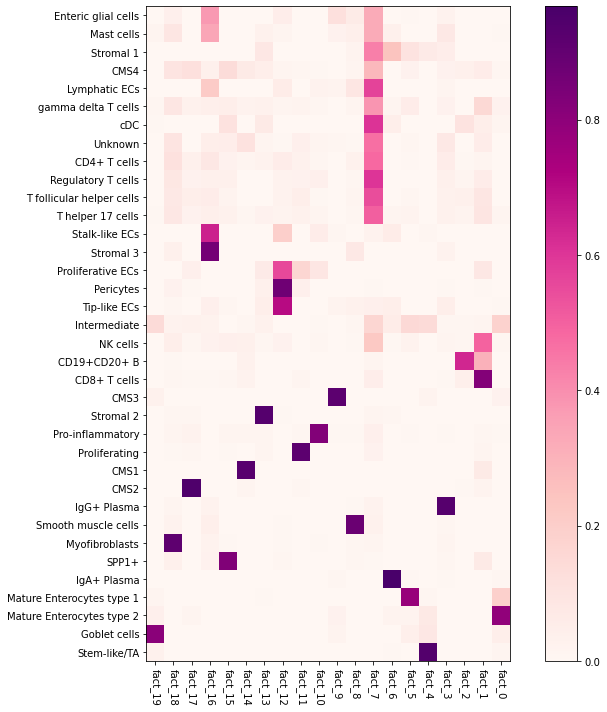

In [76]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 10])